In [1]:
import pandas as pd
import geopandas as gpd
import movingpandas as mpd
import numpy as np
from datetime import timedelta, datetime
import folium
import time
import warnings
import pickle
import sys

warnings.filterwarnings('ignore')

print("Geopandas has version {}".format(gpd.__version__))
print("Movingpandas has version {}".format(mpd.__version__))

Geopandas has version 0.13.2
Movingpandas has version 0.17.1


In [2]:
# add paths for modules
sys.path.append('../models')
# import modules
import visualize
from maritime_traffic_network import MaritimeTrafficNetwork

In [3]:
# load network from pickle
model = '202204_waypoints_DP10_HDBSCAN12_tromso_full_UTM'
model_path = '../../models/networks/best_networks/' + model + '.obj'
fileObj = open(model_path, 'rb')
network = pickle.load(fileObj)
fileObj.close()
network.hyperparameters

{'Data': '../../data/processed/202204_points_tromso_cleaned_meta_full_dualSplit_2.parquet',
 'DP_tolerance': 10,
 'clustering_method': 'HDBSCAN',
 'clustering_metric': 'mahalanobis',
 'clustering_min_samples': 12,
 'clustering_min_cluster_size': 12,
 'clustering_eps': 0,
 'clustering_metric_V': array([[1.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00],
        [0.e+00, 1.e+00, 0.e+00, 0.e+00, 0.e+00],
        [0.e+00, 0.e+00, 1.e-02, 0.e+00, 0.e+00],
        [0.e+00, 0.e+00, 0.e+00, 1.e-02, 0.e+00],
        [0.e+00, 0.e+00, 0.e+00, 0.e+00, 5.e-04]]),
 'graph_generation_max_distance': 10,
 'graph_generation_max_angle': 45}

In [4]:
# merge stop points
network.merge_stop_points(max_speed=2)

In [5]:
# prune
network.prune_graph(1)

Pruning...
------------------------
Pruned Graph:
Number of nodes: 565 (1 isolated)
Number of edges: 2181
------------------------


In [10]:
# plot network and basemap
network.prune_graph(100)
map = network.map_graph(pruned=True, center=[69, 19])  #tromso: center=[69, 19]
network.prune_graph(1)
# add some trajectories
all_trajectories = network.trajectories
#selection_start = 0
#selection_end = len(all_trajectories)
#selection_step = 15
#selection = np.arange(selection_start, selection_end, selection_step)
selection = [0, 1, 10, 100, 500]
mmsis = network.gdf.mmsi.unique()[selection]
trajectories = all_trajectories.filter('mmsi', mmsis.tolist())
for mmsi in mmsis:
    trajectory = all_trajectories.get_trajectory(mmsi)
    path_df, evaluation_results = network.trajectory_to_path(trajectory, verbose=False)
    path_df_sspd, evaluation_results_sspd = network.trajectory_to_path_sspd(trajectory, verbose=False)
    print(mmsi, evaluation_results['message'])
    print(mmsi, evaluation_results_sspd['message'])
    print('------------------')
    try:
        map = trajectory.to_line_gdf()[['geometry', 'mmsi', 'skipsgruppe']].explore(m=map, style_kwds={'weight':3, 'color':'black', 'opacity':1}, 
                                                                      name=mmsi+' trajectory')
        map = path_df.explore(m=map, name=mmsi+' edge_sequence ', style_kwds={'weight':3, 'color':'yellow', 'opacity':1})
        map = path_df_sspd.explore(m=map, name=mmsi+' edge_sequence sspd', style_kwds={'weight':3, 'color':'cyan', 'opacity':1})
    except:
        print(mmsi+': no path found')

folium.LayerControl().add_to(map)
#map

Pruning...
------------------------
Pruned Graph:
Number of nodes: 565 (1 isolated)
Number of edges: 1453
------------------------
Pruning...
------------------------
Pruned Graph:
Number of nodes: 565 (1 isolated)
Number of edges: 2181
------------------------
210055000_4_2022-04-01 04:02:37 0    no_intersects
Name: message, dtype: object
210055000_4_2022-04-01 04:02:37 0    no_intersects
Name: message, dtype: object
------------------
210055000_4_2022-04-01 04:02:37: no path found
210055000_4_2022-04-01 04:09:32 0    success
Name: message, dtype: object
210055000_4_2022-04-01 04:09:32 0    success
Name: message, dtype: object
------------------
211211730_1_2022-04-01 09:12:01 0    no_intersects
Name: message, dtype: object
211211730_1_2022-04-01 09:12:01 0    no_intersects
Name: message, dtype: object
------------------
211211730_1_2022-04-01 09:12:01: no path found
244859000_0_2022-04-24 07:05:18 0    no_intersects
Name: message, dtype: object
244859000_0_2022-04-24 07:05:18 0    no

In [11]:
map.save('../../reports/maps/'+model+'.html')

In [8]:
evaluation_results_sspd

,mmsi,SSPD,distances,fraction_covered,message
0,257262500_17_2022-04-03 17:01:41,53.329358,"[55.37602068167559, 13.591343668325079, 10.625...",0.99828,success


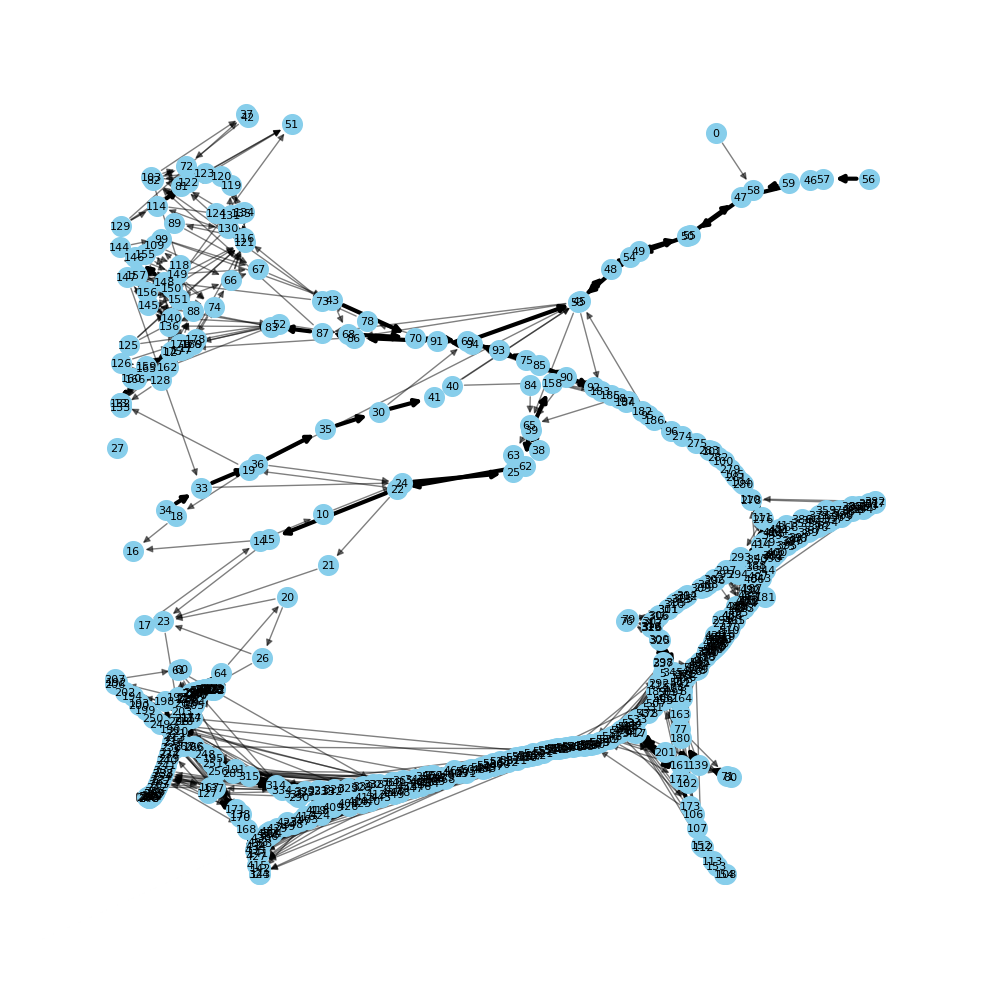

In [9]:
network.plot_graph_canvas()